##Corner detection using OpenCV

In [ ]:
import cv2
import numpy as np
import operator
import os
from google.colab.patches import cv2_imshow

In [ ]:
#find four corners of sudoku grid using OpenCV functions
def find_corners(sudoku_image):
  sudoku_image = cv2.cvtColor(sudoku_image, cv2.COLOR_BGR2GRAY)
  cv2.GaussianBlur(sudoku_image, (9, 9), 0, sudoku_image)
  cv2.adaptiveThreshold(sudoku_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2, sudoku_image)

  contours = cv2.findContours(sudoku_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  contours = sorted(contours, key=cv2.contourArea, reverse=True) #sort contours to fing the largest one
  largest_contour = contours[0]

  corners1 = largest_contour[:4].copy()
  corners2 = largest_contour[:4].copy()

  #find corners of the sudoku
  #we for 2 squares and than check which square has larger area -> works also for rotated images
  for pt in largest_contour:
    if pt[0][0] + pt[0][1] < corners1[0][0][0] + corners1[0][0][1]: corners1[0] = pt
    if pt[0][0] - pt[0][1] > corners1[1][0][0] - corners1[1][0][1]: corners1[1] = pt
    if pt[0][0] + pt[0][1] > corners1[2][0][0] + corners1[2][0][1]: corners1[2] = pt
    if pt[0][0] - pt[0][1] < corners1[3][0][0] - corners1[3][0][1]: corners1[3] = pt
    if pt[0][0] < corners2[0][0][0]: corners2[0] = pt
    if pt[0][1] < corners2[1][0][1]: corners2[1] = pt
    if pt[0][0] > corners2[2][0][0]: corners2[2] = pt
    if pt[0][1] > corners2[3][0][1]: corners2[3] = pt
  if cv2.contourArea(corners1) > cv2.contourArea(corners2):
    return corners1.squeeze()
  else:
    return corners2.squeeze()

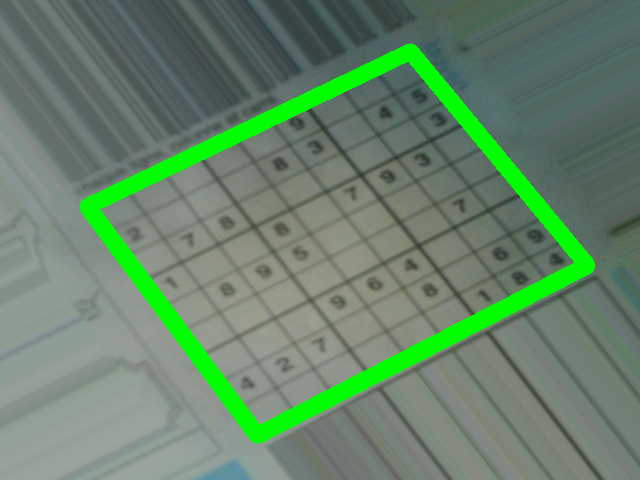

In [ ]:
#testing
image = cv2.imread("drive/MyDrive/Sudoku/sudoku_data_aug/63.jpg")
corners = find_corners(image)
cv2.drawContours(image, corners, -1, (0,255,0), 15)
cv2_imshow(image)

In [ ]:
#more_testing...
directory = 'drive/MyDrive/Sudoku/sudoku_data_aug/'
i = 0
for filename in os.listdir(directory):
  if filename.endswith('.jpg'):
    image = cv2.imread(directory + filename)
    corners = find_corners(image)
    #cv2.drawContours(image, corners, -1, (0,255,0), 15)
    #cv2.imwrite("drive/MyDrive/Sudoku/sudoku_data_aug_corners/" + filename, image)
    i += 1
    if i == 100:
      break

##Data augmentation and preprocessing

In [ ]:
import os
import json
import pandas as pd
import albumentations as A
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#extract sudoku image metadata and save them into csv file
ids = [int(filename[5:filename.index(".")]) for filename in os.listdir("drive/MyDrive/Sudoku/sudoku_data/") if filename.endswith(".dat")]
sudokus_df = pd.DataFrame(columns=["nums", "res_x", "res_y", "p1_x", "p1_y", "p2_x", "p2_y", "p3_x", "p3_y", "p4_x", "p4_y"], index=ids)

#read info about sudokus (resolution and numbers) from .dat files and save them into dataframe
for filename in os.listdir("drive/MyDrive/Sudoku/sudoku_data/"):
  if filename.endswith(".dat"):
    with open("drive/MyDrive/Sudoku/sudoku_data/" + filename) as f:
      id = int(filename[5:filename.index(".")])
      lines = f.readlines()
      res_x, res_y = map(int, lines[1][:lines[1].index(":")].split("x"))
      sudoku_nums = "".join([lines[i].strip().replace(" ", "") for i in range(2, len(lines))])

      sudokus_df.loc[id]["res_x"] = res_x
      sudokus_df.loc[id]["res_y"] = res_y
      sudokus_df.loc[id]["nums"] = sudoku_nums

#read corner positions from .json file
json_file = open("drive/MyDrive/Sudoku/sudoku_data/corners.json")
corners_data = json.load(json_file)

for item in corners_data["items"]:
  sudokus_df.loc[int(item["id"][5:])]["p1_x"] = float(item["annotations"][0]["points"][0])
  sudokus_df.loc[int(item["id"][5:])]["p1_y"] = float(item["annotations"][0]["points"][1])
  sudokus_df.loc[int(item["id"][5:])]["p2_x"] = float(item["annotations"][0]["points"][2])
  sudokus_df.loc[int(item["id"][5:])]["p2_y"] = float(item["annotations"][0]["points"][3])
  sudokus_df.loc[int(item["id"][5:])]["p3_x"] = float(item["annotations"][0]["points"][4])
  sudokus_df.loc[int(item["id"][5:])]["p3_y"] = float(item["annotations"][0]["points"][5])
  sudokus_df.loc[int(item["id"][5:])]["p4_x"] = float(item["annotations"][0]["points"][6])
  sudokus_df.loc[int(item["id"][5:])]["p4_y"] = float(item["annotations"][0]["points"][7])

#save sudoku image info into csv
sudokus_df.to_csv("drive/MyDrive/Sudoku/sudoku_data/sudoku_images_data.csv")

In [ ]:
#data augmentation of sudoku images

#define transformation for data augmentation
#we randomly rotated images and change their brightness and contrast
transform = A.Compose([A.RandomBrightnessContrast(),
                       A.SafeRotate(limit = 45, p = 1, border_mode = cv2.BORDER_REPLICATE)], keypoint_params=A.KeypointParams(format='xy'))

id_counter = 0
sudoku_df = pd.read_csv("drive/MyDrive/Sudoku/sudoku_data/sudoku_images_data.csv")
sudoku_df_aug = pd.DataFrame(columns=["nums", "res_x", "res_y", "p1_x", "p1_y", "p2_x", "p2_y", "p3_x", "p3_y", "p4_x", "p4_y"])

for filename in os.listdir("drive/MyDrive/Sudoku/sudoku_data/"):
  if filename.endswith(".jpg"):
    #read image and corner positions
    sudoku_img = cv2.imread("drive/MyDrive/Sudoku/sudoku_data/" + filename)
    sudoku_img = cv2.cvtColor(sudoku_img, cv2.COLOR_BGR2RGB)
    img_id = int(filename[5:filename.index(".")])
    keypoints = []
    keypoints.append(tuple(sudokus_df.loc[img_id][["p1_x", "p1_y"]]))
    keypoints.append(tuple(sudokus_df.loc[img_id][["p2_x", "p2_y"]]))
    keypoints.append(tuple(sudokus_df.loc[img_id][["p3_x", "p3_y"]]))
    keypoints.append(tuple(sudokus_df.loc[img_id][["p4_x", "p4_y"]]))

    #transform images and keypoints
    #we augment each image into 20 new ones
    for i in range(20):
      transformed = transform(image=sudoku_img, keypoints=keypoints) #apply transformation on keypoints and images
      transformed_img = transformed["image"]
      keypoints_transf = transformed["keypoints"]
      transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR)
      cv2.imwrite("drive/MyDrive/Sudoku/sudoku_data_aug/" + str(id_counter) + ".jpg", transformed_img)

      #save transformed keypoints into csv
      sudoku_df_aug.loc[id_counter] = [sudokus_df.loc[img_id]["nums"], sudokus_df.loc[img_id]["res_x"], sudokus_df.loc[img_id]["res_y"],
                                       keypoints_transf[0][0], keypoints_transf[0][1], keypoints_transf[1][0], keypoints_transf[1][1],
                                       keypoints_transf[2][0], keypoints_transf[2][1], keypoints_transf[3][0], keypoints_transf[3][1]]
      id_counter += 1

sudoku_df_aug.to_csv("drive/MyDrive/Sudoku/sudoku_data_aug.csv")

##Corner detection using neural network

This doesn't work yet. I'll come back to it later.

In [ ]:
import cv2
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
import os
import pandas as pd
import torchvision
from google.colab.patches import cv2_imshow

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 10.3 MB/s eta 0:00:00


In [ ]:
!unrar x /content/drive/MyDrive/Sudoku/yolo_data.rar

In [ ]:
#dataset of sudoku images; it reads images from jpg files and image details from csv file
class SudokuCornerDataset(Dataset):
  def __init__(self, root_dir, csv_path, output_size):
    self.root_dir = root_dir
    self.csv_path = csv_path
    self.output_size = output_size
    self.sudoku_df = pd.read_csv(csv_path)

  #we resize the image to output_size and return image and keypoints
  def __getitem__(self, index):
    img_name = os.path.join(self.root_dir, str(index) + ".jpg")
    image = io.imread(img_name)
    keypoints = self.sudoku_df.loc[index][4:]
    keypoints = np.array([keypoints], dtype=float).reshape(-1, 2)

    h, w = image.shape[:2]
    image = transform.resize(image, (self.output_size[0], self.output_size[1]))
    keypoints = keypoints * [self.output_size[0] / w, self.output_size[1] / h]

    image = image.transpose((2, 0, 1))

    return image, keypoints

  def __len__(self):
      return len(self.sudoku_df)

In [ ]:
#implementation of object keypoint similarity loss
#we consider all corners to have same weigth
#https://learnopencv.com/object-keypoint-similarity/
class OKSLoss(nn.Module):
  def __init__(self):
    return

  def forward(self, pred, target):
    scale = cv2.contourArea(pred.numpy().astype(int))
    oks = 0.25*torch.exp(-((target - pred)*(target - pred)).sum(dim=1)/(2*scale)).sum(dim=0)
    return 1 - oks

In [ ]:
#test precision of OpenCV corner detection on the dataset
dataset = SudokuCornerDataset("drive/MyDrive/Sudoku/sudoku_data_aug/", "drive/MyDrive/Sudoku/sudoku_data_aug.csv", (400, 400))
loader = DataLoader(dataset, batch_size=1, shuffle=False)
images, corners = next(iter(loader))
N_images = len(dataset)

loss = OKSLoss()
total_loss = 0

for i, (image, corners_target) in enumerate(loader):
  image = (image.squeeze().numpy().transpose((1, 2, 0))*255).astype("uint8")
  corners_pred = torch.Tensor(find_corners(image))
  corners_target = corners_target.squeeze()
  total_loss += loss.forward(corners_pred, corners_target)
  if i % 100 == 0:
    print("Image number", i)
  if i == N_images:
    break
print(total_loss / N_images)

In [ ]:
#prepare dataset for YOLOv8
def save_yolo_dataset(project_path="drive/MyDrive/Sudoku/", train_size=0.8, test_size=0.2):
  #read csv with image info
  sudoku_df = pd.read_csv(project_path + "sudoku_data_aug.csv")

  #save training data
  for i in range(len(sudoku_df)):
    sudoku_img = cv2.imread(f"{project_path}/sudoku_data_aug/{i}.jpg")
    if i % 100 == 0:
      print(f"Image {i} processed")

    #load and scale keypoints to <0, 1>
    keypoints = np.array(sudoku_df.loc[i][4:], dtype="float32")
    keypoints[::2] /= sudoku_img.shape[1]
    keypoints[1::2] /= sudoku_img.shape[0]

    #find bounding box center, width and heigth
    box_x = (keypoints[::2].min() + keypoints[::2].max()) / 2
    box_y = (keypoints[1::2].min() + keypoints[1::2].max()) / 2
    box_width = keypoints[::2].max() - keypoints[::2].min()
    box_heigth = keypoints[1::2].max() - keypoints[1::2].min()
    if box_x > 1 or box_y > 1 or box_width > 1 or box_heigth > 1 or keypoints.max() > 1:
      print(i, box_x, box_y, box_width, box_heigth, keypoints)

    line = f"0 {box_x} {box_y} {box_width} {box_heigth} "
    line += " ".join(list(keypoints.astype("str")))

    if i < int(train_size*len(sudoku_df)):
      with open(f"{project_path}yolo_data/labels/train/{i}.txt", 'w') as f:
        f.write(line)
    else:
      with open(f"{project_path}yolo_data/labels/val/{i}.txt", 'w') as f:
        f.write(line)

save_yolo_dataset()

In [ ]:
#model = YOLO("drive/MyDrive/Sudoku/runs/pose/train/weights/best.pt")
model = YOLO('yolov8n-pose.pt')

model.train(data="/content/yolo_data/config.yaml", epochs=30, dropout=0.8)
model.export(format="onnx")


image 1/1 /content/drive/MyDrive/Sudoku/yolo_data/images/val/3798.jpg: 640x480 1 sudoku, 125.8ms
Speed: 2.7ms preprocess, 125.8ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 480)


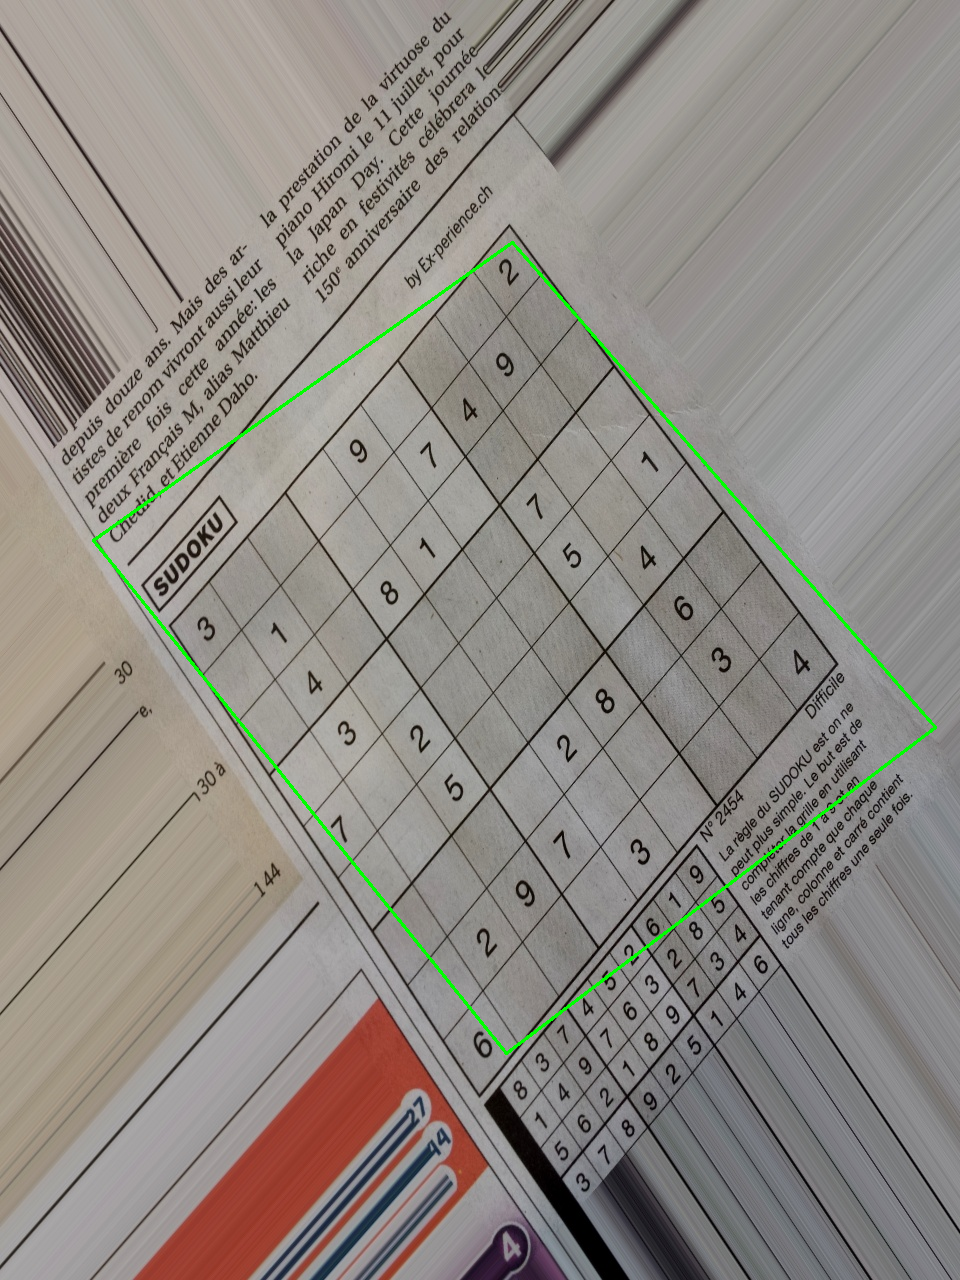

In [ ]:
image_path = "/content/drive/MyDrive/Sudoku/yolo_data/images/val/3798.jpg"
image = cv2.imread(image_path)
result = model(image_path)[0]
contours = [np.array(result[0].keypoints.data.cpu()).squeeze().astype(int)]
cv2.drawContours(image, contours, -1, (0,255,0), 2)
cv2_imshow(image)

##Using neural network to recognize digits

In [1]:
import cv2
import torch
import numpy as np
import os
import pandas as pd
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms
from google.colab.patches import cv2_imshow
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import WeightedRandomSampler

In [6]:
!pip install torchmetrics --quiet
!pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from torchmetrics import ConfusionMatrix, Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 18.5 MB/s eta 0:00:00


In [4]:
n_classes = 10

#class representing dataset of images of printed sudoku digits from photos
class SudokuNumberDataset(Dataset):
  def __init__(self, root_dir, csv_path, output_size, n_images_to_process=4000):
    self.sudoku_df = pd.read_csv(csv_path) #dataframe containing info about sudoku photos
    self.n_images = n_images_to_process*81 #number of digit images

    #create empty tensors to store digit images and labels in
    self.X = torch.empty((self.n_images, 1, output_size[0], output_size[1]))
    self.y = torch.empty(self.n_images, dtype=torch.long)

    #ids of images from the original dataset
    #images from data augmentation are stored consecutively so we want to sample across the whole dataset
    original_ids = np.linspace(0, 3999, n_images_to_process).astype(int)


    for id in range(n_images_to_process):
      #load greyscale images and corner keypoints
      img_name = os.path.join(root_dir, str(original_ids[id]) + ".jpg")
      image = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2GRAY)
      keypoints = np.array(self.sudoku_df.loc[original_ids[id]][4:]).reshape((4, 2)).astype("float32")

      grid_side = max([np.sqrt(p[0]*p[0] + p[1]*p[1]) for p in keypoints]) #find longes distance between corners

      #transform the sudoku image to a square
      keypoints_new = np.array([[0, 0], [grid_side - 1, 0], [grid_side - 1, grid_side - 1], [0, grid_side - 1]], dtype='float32')
      transform = cv2.getPerspectiveTransform(keypoints, keypoints_new)
      image = cv2.warpPerspective(image, transform, (int(grid_side), int(grid_side)))

      #cut the square sudoku image into images of individual cells
      cell_side = grid_side / 9
      for i in range(9):
        for j in range(9):
          top_left = (int(i * cell_side), int(j * cell_side))
          bottom_right = (int((i + 1) * cell_side), int((j + 1) * cell_side))
          number_image = image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
          number_image = cv2.resize(number_image, output_size)
          self.X[id*81 + i*9 + j] = torch.Tensor(number_image).unsqueeze(0)
          self.y[id*81 + i*9 + j] = torch.tensor(int(self.sudoku_df.loc[original_ids[id]]["nums"][i*9 + j]))

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
      return self.n_images

  #normalize the images
  def normalize(self, mean=None, std=None):
    if mean == None and std == None:
      mean = self.X.mean((0, 2, 3))[:, None, None]
      std = self.X.std((0, 2, 3))[:, None, None]
      print("Mean:", mean, "Std:", std)
      self.X = (self.X - mean) / std

In [7]:
#a convolutional neural network to classify digits from sudoku photos
class DigitClassifier(pl.LightningModule):
  def __init__(self, image_shape, learning_rate=0.1):
    super().__init__()
    self.loss_fn = nn.CrossEntropyLoss()
    self.learning_rate = learning_rate

    #convolutional part of the network
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

    conv_output_shape = (int(((image_shape[0] - 2) / 2 - 2) / 2),
                         int(((image_shape[1] - 2) / 2 - 2) / 2))
    #linear part of the network
    self.linear_layers = nn.Sequential(
        nn.Linear(in_features=conv_output_shape[0]*conv_output_shape[1]*24, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64, out_features=n_classes)
        )

  def forward(self, x):
    y = self.cnn_layers(x)
    y = y.view(y.size(0), -1)
    y = self.linear_layers(y)
    y = F.softmax(y, dim=1)
    return y

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = self.loss_fn(y_hat, y)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.loss_fn(y_hat, y)
    accuracy = Accuracy(task="multiclass", num_classes=10).to("cuda:0")
    self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('acc', accuracy(y_hat, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def predict_step(self, batch, batch_idx):
    x, _ = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return SGD(self.parameters(), lr=self.learning_rate)

In [8]:
output_size = (28, 28)#size of a single digit image
dataset = SudokuNumberDataset("drive/MyDrive/Sudoku/sudoku_data_aug/", "drive/MyDrive/Sudoku/sudoku_data_aug.csv", output_size, 1000)#load digit dataset
dataset.normalize()

Mean: tensor([[[139.4450]]]) Std: tensor([[[37.7531]]])


In [ ]:
#print images and labels - TO BE DELETED
for i in range(0, 100):
  print(dataset.y[i])
  cv2_imshow(np.array(dataset.X[i].squeeze()))

In [ ]:
#split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

#dataset is unbalanced (we have too many empty cells)
#we calculate sampling weights and use weighted sampling to solve this
class_weights = [1 / (dataset.y == i).sum() for i in range(n_classes)]
weights = [class_weights[sample[1]] for sample in train_dataset]

#create data loaders
sampler = WeightedRandomSampler(weights, len(train_dataset), replacement=True)
data_loader_train = DataLoader(train_dataset, batch_size=64, sampler=sampler)
data_loader_val = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
#train the digit classifier
logger = CSVLogger("logs", name="DigitClassifier")
model = DigitClassifier(output_size, 0.1)

ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1
trainer = pl.Trainer(logger=logger, devices=ngpus, accelerator="gpu" if ngpus > 0 else None, max_epochs=30)

trainer.fit(model, data_loader_train, data_loader_val)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | CrossEntropyLoss | 0     
1 | cnn_layers    | Sequential       | 2.7 K 
2 | linear_layers | Sequential       | 39.1 K
---------------------------------------------------
41.9 K    Trainable params
0         Non-trainable params
41.9 K    Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [9]:
model = torch.jit.load('digitCls.pt')
model.eval()
y_hat = model(val_dataset.dataset[val_dataset.indices][0]) #predictions for validation set

NameError: ignored

In [ ]:
predictions = y_hat.argmax(dim=1)
gt = val_dataset.dataset[val_dataset.indices][1]
conf_matrix = ConfusionMatrix(task="multiclass", num_classes = 10)
cm = conf_matrix(predictions, gt)
print(cm)

tensor([[10373,     0,     0,     0,     0,     1,     0,     2,     0,     0],
        [    0,   612,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,     0,   683,     0,     0,     0,     0,     1,     0,     0],
        [    1,     0,     0,   679,     0,     0,     0,     0,     0,     0],
        [    0,     0,     0,     0,   625,     0,     0,     0,     0,     0],
        [    0,     1,     0,     2,     2,   629,     2,     0,     0,     0],
        [    0,     0,     0,     0,     0,     0,   564,     0,     0,     1],
        [    0,     0,     0,     0,     0,     0,     0,   668,     0,     0],
        [    0,     0,     0,     0,     0,     0,     2,     0,   738,     0],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,   614]])


In [ ]:
print((torch.logical_and(predictions == gt, predictions != 0)).sum() / (predictions != 0).sum())

In [ ]:
cm.sum(dim=1)

tensor([10358,   665,   608,   627,   660,   623,   536,   696,   725,   702])

In [10]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('digitCls.pt') # Save

## Image processing pipeline

In [11]:
def solve(image):
  mean = 139.445
  std = 37.7531

  #load digit classification model
  model = torch.jit.load('digitCls.pt')
  model.eval()

  #transform into greyscale
  sudoku_image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  sudoku_image = sudoku_image_grayscale.copy()

  #find contours
  cv2.GaussianBlur(sudoku_image, (9, 9), 0, sudoku_image)
  cv2.adaptiveThreshold(sudoku_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2, sudoku_image)
  contours = cv2.findContours(sudoku_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  #there are no contours, no sudoku found -> return empty string
  if len(contours) == 0:
    return ""

  contours = sorted(contours, key=cv2.contourArea, reverse=True) #sort contours to find the largest one
  largest_contour = contours[0]

  corners1 = largest_contour[:4].copy()
  corners2 = largest_contour[:4].copy()

  #find corners of the sudoku
  #we search for 2 squares and than check which square has larger area -> works also for rotated images
  for pt in largest_contour:
    if pt[0][0] + pt[0][1] < corners1[0][0][0] + corners1[0][0][1]: corners1[0] = pt
    if pt[0][0] - pt[0][1] > corners1[1][0][0] - corners1[1][0][1]: corners1[1] = pt
    if pt[0][0] + pt[0][1] > corners1[2][0][0] + corners1[2][0][1]: corners1[2] = pt
    if pt[0][0] - pt[0][1] < corners1[3][0][0] - corners1[3][0][1]: corners1[3] = pt
    if pt[0][0] < corners2[0][0][0]: corners2[0] = pt
    if pt[0][1] < corners2[1][0][1]: corners2[1] = pt
    if pt[0][0] > corners2[2][0][0]: corners2[2] = pt
    if pt[0][1] > corners2[3][0][1]: corners2[3] = pt

  #compare the areas
  corners = np.empty(0)
  if cv2.contourArea(corners1) > cv2.contourArea(corners2):
    corners = corners1.squeeze()
  else:
    corners = corners2.squeeze()

  grid_side = max([np.sqrt(p[0]*p[0] + p[1]*p[1]) for p in corners]) #find longes distance between corners

  #transform the sudoku image to a square
  corners_new = np.array([[0, 0], [grid_side - 1, 0], [grid_side - 1, grid_side - 1], [0, grid_side - 1]], dtype="float32")
  transform = cv2.getPerspectiveTransform(corners.astype("float32"), corners_new)
  sudoku_image_grayscale = cv2.warpPerspective(sudoku_image_grayscale, transform, (int(grid_side), int(grid_side)))

  #cut the square sudoku image into images of individual cells and recognize digits in cells
  output = ""
  cell_side = grid_side / 9
  for i in range(9):
    for j in range(9):
      top_left = (int(i * cell_side), int(j * cell_side))
      bottom_right = (int((i + 1) * cell_side), int((j + 1) * cell_side))
      number_image = sudoku_image_grayscale[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
      number_image = torch.Tensor(cv2.resize(number_image, (28, 28))).unsqueeze(0).unsqueeze(0)
      cv2_imshow(np.array(number_image.detach().squeeze()))
      number_image = (number_image - mean) / std
      pred = str(np.array(model(number_image).argmax().detach()))
      print(pred)
      output += pred
  return output #return recognized digits as a string



In [12]:
image = cv2.imread("drive/MyDrive/Sudoku/sudoku_data/image1.jpg")

In [13]:
solve(image)

0


0


0


7


0


0


0


8


0


0


9


0


0


0


3


1


0


0


0


0


6


8


0


5


0


7


0


0


2


0


6


0


0


0


4


9


0


0


0


2


0


0


0


5


0


0


0


8


0


4


0


0


0


7


0


0


0


9


0


0


0


3


0


3


7


0


0


0


0


0


0


6


1


0


5


0


0


4


0


0


0


'000700080090003100006805070020600049000200050008040007000900030370000006105004000'

In [ ]:
val_dataset.dataset[val_dataset.indices][0].shape

torch.Size([16200, 1, 28, 28])